[View in Colaboratory](https://colab.research.google.com/github/keicoon/AutoEncoder/blob/master/VAE.ipynb)

## Variational Auto Encoder
- guide : https://www.shakirm.com/papers/VITutorial.pdf

In [1]:
!pip install tqdm

In [2]:
import numpy as np
import tensorflow as tf

from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
n_z = 10
def VAE(X):
  EPSILON = 1e-10
  # encoder
  f1 = tf.layers.dense(X, 512, activation=tf.nn.relu)
  f2 = tf.layers.dense(f1, 512, activation=tf.nn.relu)
  
  mu = tf.layers.dense(f2, n_z)
  log_sigma = tf.layers.dense(f2, n_z)
  eps = tf.random_normal(shape=tf.shape(log_sigma))
  
  z = mu + tf.sqrt(tf.exp(log_sigma)) * eps
  # decoder
  g1 = tf.layers.dense(z, 512, activation=tf.nn.relu)
  g2 = tf.layers.dense(g1, 512, activation=tf.nn.relu)
  
  _X = tf.layers.dense(g2, 784, activation=tf.nn.sigmoid)
  # NOTE: binary-cross-entropy
  recon_loss = -tf.reduce_sum(X * tf.log(EPSILON + _X) + (1 - X) * tf.log(EPSILON + (1 - _X)), axis=1)
  latent_loss = -0.5 * tf.reduce_sum(1 + log_sigma - tf.square(mu) - tf.exp(log_sigma), axis=1)
  
  loss = tf.reduce_mean(tf.reduce_mean(recon_loss) + tf.reduce_mean(latent_loss))
  
  return _X, z, loss

In [0]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

tf.reset_default_graph()

batch_size = 256
n_samples = int(mnist.train.num_examples)
total_batch = int(n_samples / batch_size)

X = tf.placeholder(tf.float32, [None, 784])
_X, z, loss = VAE(X)

train_op = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(loss)

sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())

In [43]:
def train():
  training_epochs = 10
  
  for epoch in range(training_epochs):
    avg_loss = 0.
    
    pbar = tqdm(range(total_batch))
    
    for i in pbar:
      batch_x, _ = mnist.train.next_batch(batch_size, shuffle=True)
      
      _, total_loss = sess.run([train_op, loss], feed_dict={X: batch_x})
      
      avg_loss += total_loss / total_batch
      pbar.set_description("loss : %f" % avg_loss)
    
train()

loss : 5.539761:   0%|          | 0/214 [00:00<?, ?it/s]

loss : 6.222909:   4%|▍         | 9/214 [00:00<00:03, 65.06it/s]

loss : 6.605763:   5%|▍         | 10/214 [00:00<00:02, 71.09it/s]

loss : 107.731477: 100%|██████████| 214/214 [00:02<00:00, 84.63it/s]


Original Images


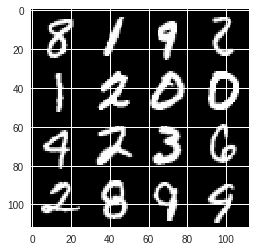

Reconstructed Images


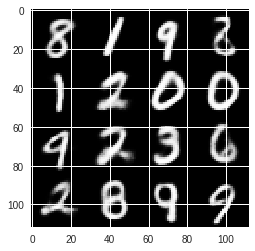

In [44]:
def test():
  n = 4
    
  canvas_orig = np.empty((28 * n, 28 * n))
  canvas_recon = np.empty((28 * n, 28 * n))
  for i in range(n):
      batch_x, _ = mnist.test.next_batch(n)

      recon = sess.run(_X, feed_dict={X: batch_x})

      # Display original images
      for j in range(n):
          # Draw the generated digits
          canvas_orig[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = batch_x[j].reshape([28, 28])
      # Display reconstructed images
      for j in range(n):
          # Draw the generated digits
          canvas_recon[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = recon[j].reshape([28, 28])

  print("Original Images")     
  plt.figure(figsize=(n, n))
  plt.imshow(canvas_orig, origin="upper", cmap="gray")
  plt.show()

  print("Reconstructed Images")
  plt.figure(figsize=(n, n))
  plt.imshow(canvas_recon, origin="upper", cmap="gray")
  plt.show()

test()

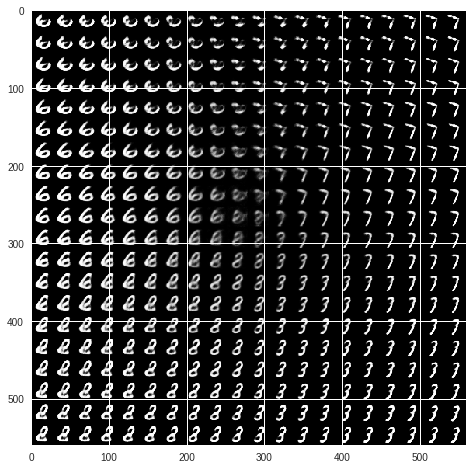

In [46]:
n = 20
x = np.linspace(-3, 3, n)
y = np.linspace(-3, 3, n)

I_latent = np.empty((28 * n, 28 * n))

for i, yi in enumerate(x):
    for j, xi in enumerate(y):
        batch_z = np.array([np.tile([xi, yi], n_z // 2)] * batch_size)
        recon = sess.run(_X, feed_dict={z: batch_z})
        I_latent[(n - i - 1) * 28:(n - i) * 28, j * 28:(j + 1) * 28] = recon[0].reshape(28, 28)

plt.figure(figsize=(8, 8))
plt.imshow(I_latent, cmap="gray")